In [1]:
import pandas as pd
import numpy as np
import random as r
import time 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
file_path = 'Prado_pp_df_control.pkl'
df_original = pd.read_pickle(file_path)
df = df_original.copy()
columns_to_drop = ['lead_time_mismatch', 'assignment_weekday']
df = df.drop(columns=columns_to_drop)
df.head()

,month,appointment_weekday,desired_weekday,gender,age,population_group,regime,specialties,type_of_consultation,specialty_classification,appointment_time,desired_lead_time,real_lead_time,missed_appointment
77841,may,friday,thursday,female,71,general population,contributory,sports medicine,normal,specialized,0.510417,0,1,1
77842,may,tuesday,monday,female,71,general population,contributory,sports medicine,normal,specialized,0.534722,0,1,1
77843,may,thursday,wednesday,female,71,general population,contributory,sports medicine,normal,specialized,0.527778,0,1,1
77844,may,friday,friday,female,71,general population,contributory,sports medicine,normal,specialized,0.586806,0,0,1
77845,may,tuesday,tuesday,female,72,general population,contributory,sports medicine,normal,specialized,0.541667,0,0,1


In [3]:
df = pd.get_dummies(df, drop_first=True)

df.columns = df.columns.str.replace(' ', '_')

X = df.drop(columns=['missed_appointment'])
print(X.columns)
y = df['missed_appointment']

Index(['age', 'appointment_time', 'desired_lead_time', 'real_lead_time',
       'month_august', 'month_december', 'month_february', 'month_january',
       'month_july', 'month_june', 'month_march', 'month_may',
       'month_november', 'month_october', 'month_september',
       'appointment_weekday_monday', 'appointment_weekday_saturday',
       'appointment_weekday_thursday', 'appointment_weekday_tuesday',
       'appointment_weekday_wednesday', 'desired_weekday_monday',
       'desired_weekday_saturday', 'desired_weekday_sunday',
       'desired_weekday_thursday', 'desired_weekday_tuesday',
       'desired_weekday_wednesday', 'gender_male',
       'population_group_general_population',
       'population_group_other_ethnicities',
       'population_group_reintegrated_or_demobilized',
       'population_group_street_dweller',
       'population_group_victims_of_armed_conflict', 'regime_not_applicable',
       'regime_special', 'regime_subsidized',
       'specialties_bioenergetic_med

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)
y_pred_proba = rf.predict_proba(X_test)
y_pred_proba[:,-1]
y_pred_proba_1 = y_pred_proba[:,-1]
roc_auc_score(y_test, y_pred_proba_1)

0.7307189459609932

In [6]:
# random_patient = X_test.sample(1)
# random_patient
# # inference on that random patient
# rf.predict_proba(random_patient)[:,-1][0]

In [7]:
# patient class with the attributes as the columns of the df
class Patient:
    def __init__(self, id, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.id = id
        self.proba = 0
        self.protected = False
        self.attendance = False
        self.assigned = False
        self.day_of_call = 0
        self.num_slot=-1
        self.overbooked = False

        if self.regime_subsidized == 1:
            self.protected = True

    def predict_proba(self, model):

        overbooking_proba_protected = 0.5
        overbooking_proba_non_protected = 0.5

        # prediccion sobre los atributos del paciente excepto id, predicted_proba y protected
        patient_data = pd.DataFrame([self.__dict__])
        patient_data = patient_data.drop(columns=['id', 'proba', 'protected', 'attendance', 'assigned','day_of_call','num_slot', 'overbooked'])

        # positive prediction
        prediction = model.predict_proba(patient_data)[:, -1][0]

        self.proba = prediction

        # define if patient has to be overbooked given its class
        if self.protected:
            if self.proba > overbooking_proba_protected:
                self.overbooked = True
        else:
            if self.proba > overbooking_proba_non_protected:
                self.overbooked = True

        # print(f"Patient {self.id} predicted probability: {prediction}")
        return prediction

    def properties(self):
        print(f"Patient {self.id} properties:")
        print(self.__dict__)

In [8]:
# converting all the patients to a list of patient objects
patients = [Patient(i, **row) for i, row in enumerate(X.to_dict(orient='records'))]

In [9]:
patient = patients[10]
# patient.properties()

print(f"Patient {patient.id} prediction before method: {patient.proba}")
patient.predict_proba(rf)
print(f"Patient {patient.id} prediction after method: {patient.proba}") 

patient = patients[8000]
# patient.properties()

print(f"Patient {patient.id} prediction before method: {patient.proba}")
patient.predict_proba(rf)
print(f"Patient {patient.id} prediction after method: {patient.proba}") 

Patient 10 prediction before method: 0
Patient 10 prediction after method: 0.98
Patient 8000 prediction before method: 0
Patient 8000 prediction after method: 0.01


In [10]:
patient = patients[10000]

# without value because the initial value is 0
print(f"Patient {patient.id} prediction before method: {patient.proba}")
patient.predict_proba(rf)
print(f"Patient {patient.id} prediction after predict method: {patient.proba}") 

patient.real_lead_time = 1000
patient.predict_proba(rf)

print(f"Patient {patient.id} prediction after changing lead time: {patient.proba}") 

Patient 10000 prediction before method: 0
Patient 10000 prediction after predict method: 0.24
Patient 10000 prediction after changing lead time: 0.34


In [11]:
i = 100
print(f"Patient {patients[i].id} - Protected: {patients[i].protected} (regime_subsidized {patients[i].regime_subsidized})")

i = 1725
print(f"Patient {patients[i].id} - Protected: {patients[i].protected} (regime_subsidized {patients[i].regime_subsidized})")

Patient 100 - Protected: False (regime_subsidized 0)
Patient 1725 - Protected: True (regime_subsidized 1)


In [12]:
def random_patient_sample(patients, sample_size ):
    
    filtered_patients = patients

    # inicialmente no vamos a filtrar por especialidad
    # # Filter patients by specialty (general medicine)
    # filtered_patients = [patient for patient in patients if patient.specialties_general_medicine == 1]
    
    # Randomly sample from filtered patients
    sampled_patients = [filtered_patients[i] for i in np.random.choice(len(filtered_patients), sample_size, replace=False)]
    
    return sampled_patients

In [13]:
def random_patient_sample(patients, sample_size):

    # Pecentage of protected patients in the sample
    protected_pct = 0.3

    # Separate patients into the two classes
    protected_true = [patient for patient in patients if patient.protected]
    protected_false = [patient for patient in patients if not patient.protected]

    # Calculate sample sizes for each group 
    total_sample_size = sample_size
    sample_size_protected_true = int(total_sample_size * protected_pct)
    sample_size_protected_false = total_sample_size - sample_size_protected_true

    # Randomly select samples from each group
    sample_protected_true = [protected_true[i] for i in np.random.choice(len(protected_true), sample_size_protected_true, replace=False)]
    sample_protected_false = [protected_false[i] for i in np.random.choice(len(protected_false), sample_size_protected_false, replace=False)]

    # Final stratified sample
    stratified_sample = sample_protected_true + sample_protected_false

    # Shuffle the final sample
    np.random.shuffle(stratified_sample)

    return stratified_sample

In [14]:
def asignar_dia(patient_list_sample, num_days):

    # determinar cuantos pacientes por dia
    patients_per_day = len(patient_list_sample) // num_days
 
    # asignar dia de llamada a cada paciente
    for i, patient in enumerate(patient_list_sample):
        patient.day_of_call = i//patients_per_day
        patient.id=i
        #patient.properties()

    # organizar por dia de llamada
    patient_list_sample.sort(key=lambda x:x.day_of_call)

    return patient_list_sample

# Clinic Class and simulation

In [15]:
class Clinic:
    def __init__(self, patients_data, appointments, simulation_days, num_serves, scheduling_days, num_hours_byday, slot_time, overbooking):
        # This is a list of patients to be served by the clinic
        self.simulation_days = simulation_days
        self.patients_list = patients_data
        self.num_serves = num_serves
        self.scheduling_days = scheduling_days
        self.num_hours_byday = num_hours_byday
        self.slot_time = slot_time # Minutes
        self.num_slots_byday_server = int(num_hours_byday * (60/slot_time)*overbooking)
        self.service_time = np.zeros(num_serves)
        self.over_time = np.zeros(num_serves)
        self.no_shows=0
        self.refused_patients=0 
        self.total_time=0
        self.idle_time_server =np.zeros(num_serves) 
        patients_slot=1
        #Initialize the appointment with array FULL OF 0
        self.appointments=appointments
        
        # inicializando este porque si no daba error
        self.cwt_protected = 0
        self.cwt_non_protected = 0

        #Calcula el CWL, Desde el dia siguiente a ser solicitada la cita hasta el momento de la cita 
    def compute_waiting_time(self, day, slot, id):
        direct_time = 0
        total_time = 0
        hora_inicio = 6
        
        # Diferencia entre slot asignado y slot atendido * tiempo slot (minutos)
        direct_time = (slot - self.patients_list[id].num_slot) * self.slot_time
        
        total_time = int(day-self.patients_list[id].day_of_call+1)
        total_time = total_time*60*24
        minutes = (self.slot_time*(slot))+(60*hora_inicio)
        total_time = total_time+minutes

        # Se puede retornar tambien el tiempo total de espera (a consideracion)
        return direct_time
    
    def simulation(self):
        for server_idx, server in enumerate(self.appointments):
            for dia_idx, dia in enumerate(server):
                for slot_idx, slot in enumerate(dia):
                        # si no hay paciente en slot, idle system time
                        if slot.count(None) > 0:        
                                self.idle_time_server[server_idx] += self.slot_time
                                continue
                        
                        # Only one patient assigned to the slot
                        if self.not_null(slot)==1:
                            # Assiged patient MISSES APPOINTMENT -> Idle time (slot vacio)
                            if self.patients_list[slot[0]].attendance==False:
                                self.idle_time_server[server_idx]+=self.slot_time
                                self.no_shows+=1
                            # Assigned patient shows up
                            else:
                                # aqui estaba definido como patient pero la clinica no sabe que es patient, accede desde la lista de pacientes
                                if self.patients_list[slot[0]].protected == False:
                                # if patient.protected == False:
                                    self.cwt_non_protected += self.compute_waiting_time(dia_idx, slot_idx, slot[0])
                                else:
                                    self.cwt_protected += self.compute_waiting_time(dia_idx, slot_idx, slot[0])

                                self.service_time[server_idx]+=self.slot_time
                        
                        # There are no patients assigned to the slot
                        elif self.not_null(slot)==0:
                            if slot.count(None)>0:
                                self.idle_time_server[server_idx]+=self.slot_time
                                continue
                            self.idle_time_server[server_idx]+=self.slot_time
                        
                        # >1 patients assigned to the slot (OVERBOOKING)
                        else:
                            ids=[]
                            # add patients that attended to the ids list
                            for i in range(len(slot)):
                                if self.patients_list[slot[i]].attendance==True:
                                    ids.append(slot[i])
                                else:
                                    self.no_shows+=1
                            self.appointments[server_idx][dia_idx][slot_idx]=ids
                            
                            # More than one patient SHOWS UP
                            if len(ids)>1:
                                
                                # 1.1 Is this the last slot schedule for the day- Si tengo que hacer overtime

                                # El overtime lo podemos sacar al final evaluando cuantas personas llegaron totalmente
                                # La diferencia entre personas que llegaron - slots disponibles * tiempo de slot es el overtime

                                # Calcular tiempos de espera de los pacientes de overtime
                                if slot_idx==(len(self.appointments[server_idx][dia_idx])-1):
                                    self.over_time[server_idx]+=self.slot_time*(len(ids)-1)

                                    # esto se añadio, antes de añadirlo funcionaba
                                    for i in range(len(ids)):
                                        if self.patients_list[slot[i]].protected == False:
                                            self.cwt_non_protected += self.compute_waiting_time(dia_idx, slot_idx+i, ids[i])
                                        else:
                                            self.cwt_protected += self.compute_waiting_time(dia_idx, slot_idx+i, ids[i])  
                                
                                # 1.2 More than one patient SHOW-UP and is not the last slot for the server
                                else:
                                    temp_reasign=slot[1:]
                                    reasign=[]
                                    for i in range(len(temp_reasign)):
                                        if self.patients_list[temp_reasign[i]].attendance==True:
                                             reasign.append(temp_reasign[i])

                                    test = [None]
                                    test[0] = slot[0]
                                    reasign.extend(self.appointments[server_idx][dia_idx][slot_idx+1])
                                    
                                    #Como es un array natural d python no permite la indexacion de tipo [1,2,3]
                                    self.appointments[server_idx][dia_idx][slot_idx]= test
                                    self.appointments[server_idx][dia_idx][slot_idx+1]=reasign
                                    reasign=[]
                                    
                                if self.patients_list[slot[0]].protected == False:
                                    self.cwt_non_protected += self.compute_waiting_time(dia_idx, slot_idx, slot[0])
                                else:
                                    self.cwt_protected += self.compute_waiting_time(dia_idx, slot_idx, slot[0])
                            # Ninguno de los overbooked shows up
                            elif not ids:
                                self.idle_time_server[server_idx]+=self.slot_time
                            
                            # Solo uno de los overbooked shows up
                            else:
                                if self.patients_list[slot[0]].protected == False:
                                    self.cwt_non_protected += self.compute_waiting_time(dia_idx, slot_idx, slot[0])
                                else:
                                    self.cwt_protected += self.compute_waiting_time(dia_idx, slot_idx, slot[0])
    
                                self.service_time[server_idx]+=self.slot_time

    def not_null(self, lista):
        return max(len(lista) - lista.count(None), 0)
    
    def get_measures(self):

        measures = {
            "idle_time_server": self.idle_time_server.tolist(),  # NumPy array to list
            "over_time": self.over_time.tolist(), # NumPy array to list
            "no_shows": self.no_shows,
            "clients_total_waiting_time non protected class": self.cwt_non_protected,
            "clients_total_waiting_time protected class": self.cwt_protected,
            "service_time": self.service_time.tolist()  # NumPy array to list
        }
        return measures

# Scheduling policy
### Create the routines to make the scheduling appointments
1. FIFO scheduling policy
2. Overbooking policy: Make overbooking with all high probabilities when there are no available slots for the day.
3. Make overbooking with expected probabilities:
    P(Both show up) = P(1-P(A)) * (1 -P(B))
4. Make overbooking 2ATBEG 

### Custom FIFO

In [16]:
time_per_slot = 20
work_hours = 10

slots_per_day = (60//time_per_slot) * work_hours
available_slots = slots_per_day * 7
extra_pct = 0.5
# np ceil rounds up
sample_size = int(np.ceil(available_slots + (available_slots * extra_pct)))

random_sample = random_patient_sample(patients, sample_size)

assert len(random_sample) == sample_size

print([f"{patient.id}: prot {patient.protected}" for patient in random_sample])
# Contar cuantos pacientes protegidos y no protegidos hay en la muestra
protected_count = sum([patient.protected for patient in random_sample])
non_protected_count = sample_size - protected_count
print(f"Protected: {protected_count} | Non-protected: {non_protected_count}")

['8441: prot False', '48817: prot False', '8612: prot True', '76006: prot True', '103471: prot False', '93892: prot False', '76360: prot False', '37789: prot True', '90125: prot False', '84058: prot False', '90027: prot False', '27521: prot True', '66443: prot False', '46965: prot False', '27105: prot False', '51797: prot False', '44863: prot True', '94937: prot False', '21392: prot False', '29058: prot False', '93223: prot False', '59601: prot False', '65809: prot False', '35075: prot False', '69982: prot False', '42519: prot False', '79674: prot False', '1886: prot True', '86682: prot False', '54669: prot True', '89527: prot False', '74247: prot True', '50536: prot True', '68885: prot True', '74225: prot True', '96330: prot True', '40818: prot False', '57529: prot False', '24105: prot False', '7145: prot False', '98771: prot False', '87288: prot True', '1887: prot True', '84688: prot False', '78274: prot False', '65010: prot False', '75497: prot False', '51927: prot False', '30386: p

In [17]:
# tratando de traducirla al cambio de paradigma
def custom_fifo(patient_sample, appointments, verbose=False):
    
    for patient in patient_sample:
        if not patient.assigned:
            for server in range(len(appointments)):

                desired_list_index = patient.day_of_call + patient.desired_lead_time

                # definiendo los dias, no puede ir mas alla del tamaño de dias por asignar
                start_day = patient.day_of_call
                end_day = min(patient.day_of_call + 6, len(appointments[server]))

                # iterando sobre los dias definidos
                for day in range(start_day, end_day):
                    if len(appointments[server][day]) < slots_per_day:
                        appointments[server][day].append(patient)
                        patient.assigned = True
                        if verbose:
                            print(f"--- P{patient.id} | Desired {day} | Assigned {day}")
                        break
                if patient.assigned:
                    break
                
            if not patient.assigned:
                for server in range(len(appointments)):
                    for day in range(len(appointments[server])):
                        if len(appointments[server][day]) < slots_per_day:
                            appointments[server][day].append(patient)
                            patient.assigned = True
                            if verbose:
                                print(f"--- P{patient.id} | Desired {day} | Assigned {day}")
                            break
                    if patient.assigned:
                        break
                if not patient.assigned:
                    if verbose:
                        print(f"* * * Full Schedule, can not assign more patients. Patient: {patient.id}")

    if verbose:
        print("Current Schedule:")
        for server, server_apps in enumerate(appointments):
            for day, day_apps in enumerate(server_apps):
                print(f"Server {server}, Day {day} ({len(day_apps)} Patients): {[patient.id for patient in day_apps]}")
        print("\n")

    refused_patients = len([patient for patient in patient_sample if not patient.assigned])

    return appointments, refused_patients

In [18]:
# contar cuantas listas no vacias hay en determinada lista
def count_non_empty_lists(list):
    count = 0 
    # que revise los que no estan vacios o no son none 
    for entry in list:
        if entry and entry[0] != None:
            count += 1
    return count

# Ej funcionamiento
list_testing = [[None], [None], [], [1], [2], [3]]
count_non_empty_lists(list_testing)

3

In [19]:
# tratando de traducirla al cambio de paradigma
def custom_fifo(patient_sample, appointments, verbose=False):
    
    for patient in patient_sample:
        if not patient.assigned:
            for server in range(len(appointments)):

                # el paciente la desea en dia de la llamada + el tiempo deseado
                desired_list_index = patient.day_of_call + patient.desired_lead_time

                # definiendo los dias, no puede ir mas alla del tamaño de dias por asignar
                start_day = patient.day_of_call
                end_day = min(patient.day_of_call + 6, len(appointments[server]))

                # si el desired list index es mayor a 6, ese paciente no se asigna esta semana
                if desired_list_index > len(appointments[server]):
                    if verbose:
                        print(f"--- P{patient.id} | Desired {desired_list_index} | Not assigned this week")
                    break

                # si desea para esa semana y ese dia hay espacio
                if desired_list_index < len(appointments[server]) and count_non_empty_lists(appointments[server][desired_list_index]) < slots_per_day:

                    # asignarlo en el primer slot disponible de ese dia
                    for slot in range(len(appointments[server][desired_list_index])):
                        if not appointments[server][desired_list_index][slot]:
                            appointments[server][desired_list_index][slot] = patient
                            patient.assigned = True
                            if verbose:
                                print(f"--- P{patient.id} | Desired {desired_list_index} | Assigned {desired_list_index}")
                            break
                
                # si aun no se ha asignado, mirar en los dias siguientes al desired list index (hasta 6 dias) el primero donde se pueda asignar
                if not patient.assigned:
                    for day in range(desired_list_index, end_day):
                        # asignarlo en el primer slot disponible
                        for slot in range(len(appointments[server][day])):
                            if not appointments[server][day][slot]:
                                appointments[server][day][slot] = patient
                                patient.assigned = True
                                if verbose:
                                    print(f"--- P{patient.id} | Desired {desired_list_index} | Assigned {day}")
                                break
                    if patient.assigned:
                        break

                # iterando sobre los dias definidos
                for day in range(start_day, end_day):
                    if len(appointments[server][day]) < slots_per_day:
                        appointments[server][day].append(patient)
                        patient.assigned = True
                        if verbose:
                            print(f"--- P{patient.id} | Desired {day} | Assigned {day}")
                        break
                if patient.assigned:
                    break
                
            if not patient.assigned:
                for server in range(len(appointments)):
                    for day in range(len(appointments[server])):
                        if len(appointments[server][day]) < slots_per_day:
                            appointments[server][day].append(patient)
                            patient.assigned = True
                            if verbose:
                                print(f"--- P{patient.id} | Desired {day} | Assigned {day}")
                            break
                    if patient.assigned:
                        break
                if not patient.assigned:
                    if verbose:
                        print(f"* * * Full Schedule, can not assign more patients. Patient: {patient.id}")

    if verbose:
        print("Current Schedule:")
        for server, server_apps in enumerate(appointments):
            for day, day_apps in enumerate(server_apps):
                print(f"Server {server}, Day {day} ({len(day_apps)} Patients): {[patient.id for patient in day_apps]}")
        print("\n")

    refused_patients = len([patient for patient in patient_sample if not patient.assigned])

    return appointments, refused_patients

In [20]:
# tratando de traducirla al cambio de paradigma
def custom_fifo(patient_sample, appointments, verbose=False):
    
    non_assigned = 0
    for patient in patient_sample:
        for server in range(len(appointments)):

            patient.desired_lead_time = max(0, patient.desired_lead_time)

            if verbose:
                print(f"Eval P{patient.id} S{server} | Desired {patient.day_of_call + patient.desired_lead_time}")

            # el paciente desea en dia de la llamada + el tiempo deseado
            desired_list_index = patient.day_of_call + patient.desired_lead_time
            # definiendo los dias, no puede ir mas alla del tamaño de dias por asignar
            start_day = patient.day_of_call
            end_day = 6
            # end_day = min(patient.day_of_call + 6, len(appointments[server]))
            
            # si aun no se ha asignado, mirar en los dias siguientes al desired list index (hasta 6 dias) el primero donde se pueda asignar
            if not patient.assigned and desired_list_index < end_day:
                if verbose:
                    print(f"--- Trying to assign P{patient.id} | Desired {desired_list_index}")
                
                for day in range(desired_list_index, end_day+1):
                    # asignarlo en el primer slot disponible
                    for slot in range(len(appointments[server][day])):
                        if verbose:
                            # print(f"Va a evaluar en appointments[{server}][{day}][{slot}] {appointments[server][day][slot]}")
                            print("", end="")
                        
                        if appointments[server][day][slot][0] is None:
                            appointments[server][day][slot] = [patient]
                            patient.assigned = True

                            if verbose:
                                print(f"--- P{patient.id} | Desired {desired_list_index} | Assigned {day} : {patient.assigned}")
                                
                            break
                        if patient.assigned:
                            break
                    if patient.assigned:
                        break
                if patient.assigned:
                        break

                if not patient.assigned:
                    # ya este no se puede asignar
                    non_assigned += 1
                    if verbose:
                        print(f"--- P{patient.id} | Desired {desired_list_index} | Could not be assigned (Full Schedule)")
                    break

            elif desired_list_index > end_day:
                non_assigned += 1
                if verbose:
                    print(f"--- P{patient.id} | Desired {desired_list_index} | Wanted for next week")
                break

        if verbose:
            print("Current Schedule:")
            for server, server_apps in enumerate(appointments):
                for day, day_apps in enumerate(server_apps):
                    # print(f"Day {day} apps: {[pat_iter[0].id for pat_iter in day_apps if pat_iter[0].id is not None else None]}")
                    print(f"Day {day} apps: {[pat_iter[0].id if pat_iter[0] is not None else None for pat_iter in day_apps]}")
                    # print(f"Server {server}, Day {day} ({len(day_apps)} Patients): {[patient.id for patient in day_apps]}")
            print("\n")

    # refused_patients = len([patient for patient in patient_sample if not patient.assigned])

    return appointments, non_assigned

In [21]:
seed = 42
num_serves = 1
work_hours = 10
slot_time = 20
overbooking = 1.0
simulation_days = 7
num_slots_byday = (60//slot_time) * work_hours
num_simulations = 10 # Number of Monte Carlo simulations

available_slots = num_slots_byday* simulation_days 
extra_pct = 0.5

# np ceil rounds up
sample_size = int(np.ceil(available_slots + (available_slots * extra_pct)))

# Initialize the appointments
appointments = []
for _ in range(1):
    server = [] 
    for _ in range(7):
        dia = []
        for _ in range(num_slots_byday):
            slot = [None]
            dia.append(slot) 
        server.append(dia)
    appointments.append(server)

patient_sample = random_patient_sample(patients, 2050)

# for patient in patient_sample:
#     print(f"Patient {patient.id} - Desired {patient.day_of_call + patient.desired_lead_time}")

appointments_custom_fifo, non_assigned_custom_fifo = custom_fifo(patient_sample, appointments, verbose=0)

print(f"No assigned patients: {non_assigned_custom_fifo} : {non_assigned_custom_fifo/len(patient_sample)*100:.2f}%")
print(f"Appointments using custom FIFO: {appointments_custom_fifo}")

No assigned patients: 1836 : 89.56%
Appointments using custom FIFO: [[[[<__main__.Patient object at 0x28ecfcd30>], [<__main__.Patient object at 0x296bda380>], [<__main__.Patient object at 0x296b3ac80>], [<__main__.Patient object at 0x2993e1ea0>], [<__main__.Patient object at 0x298df0250>], [<__main__.Patient object at 0x2975aead0>], [<__main__.Patient object at 0x2981dc610>], [<__main__.Patient object at 0x297a03a60>], [<__main__.Patient object at 0x295dcb010>], [<__main__.Patient object at 0x296b14820>], [<__main__.Patient object at 0x296460dc0>], [<__main__.Patient object at 0x297abda20>], [<__main__.Patient object at 0x298df9c00>], [<__main__.Patient object at 0x298116290>], [<__main__.Patient object at 0x295d65e10>], [<__main__.Patient object at 0x298d8d240>], [<__main__.Patient object at 0x295de0760>], [<__main__.Patient object at 0x297532290>], [<__main__.Patient object at 0x29643cee0>], [<__main__.Patient object at 0x2993a4e20>], [<__main__.Patient object at 0x29518d690>], [<__m

In [22]:
# patient_sample = random_patient_sample(patients, 2050)

In [23]:
appointments_custom_fifo, non_assigned_custom_fifo = custom_fifo(patient_sample, appointments, verbose=0)

In [24]:
print(f"No assigned patients: {non_assigned_custom_fifo} : {non_assigned_custom_fifo/len(patient_sample)*100:.2f}%")
print(f"Appointments using custom FIFO: {appointments_custom_fifo}")

No assigned patients: 1836 : 89.56%
Appointments using custom FIFO: [[[[<__main__.Patient object at 0x28ecfcd30>], [<__main__.Patient object at 0x296bda380>], [<__main__.Patient object at 0x296b3ac80>], [<__main__.Patient object at 0x2993e1ea0>], [<__main__.Patient object at 0x298df0250>], [<__main__.Patient object at 0x2975aead0>], [<__main__.Patient object at 0x2981dc610>], [<__main__.Patient object at 0x297a03a60>], [<__main__.Patient object at 0x295dcb010>], [<__main__.Patient object at 0x296b14820>], [<__main__.Patient object at 0x296460dc0>], [<__main__.Patient object at 0x297abda20>], [<__main__.Patient object at 0x298df9c00>], [<__main__.Patient object at 0x298116290>], [<__main__.Patient object at 0x295d65e10>], [<__main__.Patient object at 0x298d8d240>], [<__main__.Patient object at 0x295de0760>], [<__main__.Patient object at 0x297532290>], [<__main__.Patient object at 0x29643cee0>], [<__main__.Patient object at 0x2993a4e20>], [<__main__.Patient object at 0x29518d690>], [<__m

### FIFO

In [25]:
def fifo(patient, appointments):
    if not patient.assigned:
        for server in range(len(appointments)):
            start_day = patient.day_of_call
            end_day = min(patient.day_of_call + 6, len(appointments[server]))
            for dia in range(start_day, end_day):
                for slot in range(len(appointments[server][dia])):
                    for id in range(len(appointments[server][dia][slot])):
                        if appointments[server][dia][slot][id] is None:
                            appointments[server][dia][slot][id] = patient.id
                            patient.num_slot=slot
                            patient.assigned = True
                                #print(f"Patient {patient.id} assigned to the first available slot within the next {simulation_days} days")                            
                            break  # Break from innermost loop
                    if patient.assigned:
                            break  # Break from middle loop
                if patient.assigned:
                        break  # Break from outer loop
            if patient.assigned:
                    break  # Break from outer loop
    return appointments

### Overbooking
Establecemos segun un threshold que pacientes se les puede hacer overbooking
1. Si se les puede hacer overbooking se busca un slot con un paciente ya asignado y se le asigna como segundo paciente.
2. Si no se le puede hacer overbooking, se busca el primer el slot que se encuentre vacio y se le asigna

In [26]:
def rule_Overbooking(patient, appointments, threshold, train_model):

    # Establece si un paciente si le puede hacer overbooking segun su probabilidad (ALTA)

    # Predice proba de inasistencia con el respectivo modelo
    patient.predict_proba(train_model)
    
    # Decide si overbook o no basado en la prediccion
    overbook=True if patient.proba>threshold else False
    
    # Si el paciente aun no se ha asignado 
    if not patient.assigned:

        start_day=patient.day_of_call
        
        # el dia final es el ultimo de la ventana de tiempo 
        # end_day=min(patient.day_of_call+6,len(appointments[0]))
        end_day=len(appointments[0])
        
        # Itera desde el dia que llama hasta el final
        for dia in range(start_day, end_day):

            # Itera sobre los slots del dia
            if not patient.assigned:
                for slot in range(len(appointments[0][dia])):
                    for server in range(len(appointments)):        
                        # Itera dentro de los slots para revisar asignaciones
                        for id in range(len(appointments[server][dia][slot])):
                            if overbook:
                                # Overbook si hay exactamente un paciente en ese slot
                                if appointments[server][dia][slot][id] is not None and len(appointments[server][dia][slot])==1:
                                    appointments[server][dia][slot].append(patient.id)
                                    patient.num_slot = slot
                                    patient.assigned = True
                                    break
                            if patient.assigned:
                                break  # romper ciclos si ya se asigno
                        if patient.assigned:
                            break  
                    if patient.assigned:
                        break 
                if patient.assigned:
                    break 

            # Si aun no se asigna es porque no se debe hacer overbooking
            if not patient.assigned:
                for slot in range(len(appointments[0][dia])):
                    for server in range(len(appointments)):        
                        for id in range(len(appointments[server][dia][slot])):
                            # asigna en un slot vacio (no overbooking)
                            if appointments[server][dia][slot][id] is  None :
                                appointments[server][dia][slot][id]= patient.id
                                patient.num_slot=slot
                                patient.assigned=True
                                break
                            if patient.assigned:
                                break
                        if patient.assigned:
                            break
                    if patient.assigned:
                        break
                if patient.assigned:
                    break  # Break from middle loop
            if patient.assigned:
                break
    
    return appointments

In [27]:
# Objetivo calcular la matriz de probabilidad solo una vez al principio y solo con los slot disponible 
# Retorna una matriz de probabilidad con todos los slots disponibles
# Retorna proba_global que es donde se encuentra disponibile y es la menor probabilidad
# Retorna proba_filled que es donde se encuentra ocupado y es la menor probabilidad
def get_proba_matrix(patient, appointments,model,threshold):
    proba_global={"proba":1000,"server":None,"dia":None,"slot":None}
    proba_filled={"proba":1000,"server":None,"dia":None,"slot":None}
    # Get the dimensions
    length1 = len(appointments)# serves
    length2 = len(appointments[0])#days
    length3 = len(appointments[0][0])#slots
    overbook=False
    cont_overbook=0

    # Create the NumPy array filled with zeros
    proba_matrix = np.ones((length1, length2, length3), dtype=float)
    dia_inicio=patient.day_of_call
    for server in range(len(appointments)):
        for dia in range(dia_inicio,len(appointments[server])):
            for slot in range(len(appointments[server][dia])):
                    if appointments[server][dia][slot][0] is None:
                        patient.real_lead_time=(dia+(slot/len(appointments[server][dia])))-patient.day_of_call 
                        proba_new=patient.predict_proba(model)
                        proba_matrix[server,dia,slot] = proba_new
                        if proba_new>threshold and dia < 3 :
                             cont_overbook+=1
                        if proba_new<proba_global["proba"]:
                            proba_global={"proba":proba_new,"server":server,"dia":dia,"slot":slot}
                    else:
                        patient.real_lead_time=(dia+(slot/len(appointments[server][dia])))-patient.day_of_call
                        proba_new=patient.predict_proba(model)
                        if proba_new>threshold and dia < 3 :
                             cont_overbook+=1
                        proba_matrix[server,dia,slot] = proba_new
                        if proba_new<proba_filled["proba"]:
                            proba_filled={"proba":proba_new,"server":server,"dia":dia,"slot":slot} 
    if cont_overbook>2*len(appointments[0])*len(appointments)*0.6:
         overbook=True
    return proba_matrix, proba_global, proba_filled,overbook

In [28]:
def low_probability(patient, appointments,threshold, general_list,train_model):
    print(type(appointments))
    proba_matrix, best_proba, filled_proba,over = get_proba_matrix(patient,appointments,train_model,0.4)
    
    
    # 1. Reviso si el lugar con menor probabilidad esta vacio para ubicarlo en ese lugar
    if best_proba["server"] is None and best_proba["proba"]<threshold:
        appointments[best_proba["server"]][best_proba["dia"]][best_proba["slot"]][0]=patient.id
        patient.assigned=True
    # 2. Si no fue asignado, 
    if not patient.assigned:
        start_day=patient.day_of_call
        #end_day=min(patient.day_of_call+6,len(appointments[0]))
        end_day=len(appointments[0])
        for dia in range(start_day,end_day):
            if not patient.assigned:
                for server in range(len(appointments)):
                    #Revisa el primer dia para no afectar su leadtime indirecto en el sistema
                    if over:
                        for slot in range(len(appointments[0][dia])):
                            for server in range(len(appointments)):        
                                for id in range(len(appointments[server][dia][slot])):
                                    if appointments[server][dia][slot][id] is not None and len(appointments[server][dia][slot])==1:
                                    # Asignar a dos pacientes con alta probabilidad
                                        if general_list[appointments[server][dia][slot][0]].proba>threshold and proba_matrix[server,dia,slot]>threshold:
                                            patient.proba=proba_matrix[server,dia,slot]
                                            appointments[server][dia][slot].append(patient.id)
                                            patient.num_slot=slot
                                            patient.assigned=True
                                            break
                                        else :
                                            appointments[server][dia][slot][id]= patient.id
                                            patient.num_slot=slot
                                            patient.assigned=True
                                            break
                                    if patient.assigned:
                                        break
                                if patient.assigned:
                                    break
                            if patient.assigned:
                                break
                else:
                    for slot in range(len(appointments[0][dia])):
                        for server in range(len(appointments)):        
                            for id in range(len(appointments[server][dia][slot])):
                                if appointments[server][dia][slot][id] is  None :
                                    appointments[server][dia][slot][id]= patient.id
                                    patient.num_slot=slot
                                    patient.assigned=True
                                    break
                                if patient.assigned:
                                    break
                            if patient.assigned:
                                break
                        if patient.assigned:
                            break
                    if patient.assigned:
                        break
                if patient.assigned:
                    break
            else:
                break
    return appointments

### Call a rule over list of patients

In [29]:
def call_a_rule (patient_list, appointments, name_rule, ml_model):
    refused_patients=0

    if name_rule=='custom_fifo':
        appointments, refused_patients = custom_fifo(patient_list, appointments, verbose=0)
        return appointments, refused_patients
    
    # Determinar procedimiento a usar segun rule name
    for patient in patient_list:

        if name_rule=='fifo':
            appointments = fifo(patient,appointments)

        # elif name_rule == 'custom_fifo':
            
            # # Initialize the appointments
            # appointment_entry_list = []
            # for _ in range(1):
            #     server = [] 
            #     for _ in range(7):
            #         dia = []
            #         for _ in range(num_slots_byday):
            #             slot = [None]
            #             dia.append(slot) 
            #         server.append(dia)
            #     appointment_entry_list.append(server)

            # appointments, refused_patients = custom_fifo(patient_list, appointments, verbose=0)
        
        elif name_rule=='overbooking_simple':

            # threshold og era 0.6
            appointments = rule_Overbooking(patient, appointments, 0.000001, ml_model)

        elif name_rule=='low_probability':
            appointments = low_probability(patient, appointments, 0.6, patient_list, ml_model)
        else:
            print("Unknown name_rule")
    
    if not patient.assigned:
                    #print(f"Patient {patient.id} could not be assigned within the next {simulation_days} days")
        refused_patients += 1
    
    return appointments, refused_patients

## Call the simulation and changing the patient attendance

In [30]:
# OPCION CON PROBA
# Run the simulation, with already defined schedule (appointments list)

def scheduling_simulation(patients_data, appointments, simulation_days, 
                          num_serves, num_hours_byday, slot_time, 
                          overbooking,ml_model, benchmark=None):    
    
    # Determine attendance for all patients comparing random P with P(no show)
    for patient in patients_data:

        if benchmark is None:
            patient.attendance=False if np.random.uniform(0, 1) < patient.predict_proba(ml_model) else True
        else:
            patient.attendance=False if np.random.uniform(0, 1) < benchmark else True
        #patient.print_non_boolean_attributes()

    clinic = Clinic(patients_data, appointments, simulation_days, num_serves, simulation_days, num_hours_byday, slot_time, overbooking)
    clinic.simulation()
    
    # Return measures
    return clinic.get_measures()

In [31]:
# OPCION EVALUANDO CON PPV, NPV del modelo
# Run the simulation, with already defined schedule (appointments list)

def scheduling_simulation(patients_data, appointments, simulation_days, 
                          num_serves, num_hours_byday, slot_time, 
                          overbooking,ml_model, benchmark=None):    
    
    protected_ppv = 0.2
    non_protected_ppv = 0.6

    protected_npv = 0.9
    protected_npv = 0.91

    # Determine attendance for all patients comparing random P with P(no show)
    for patient in patients_data:

        # defining comparison probability taking into account model precisions
        if patient.protected:
            comparison_proba = protected_ppv
        else:
            comparison_proba = non_protected_ppv

        if benchmark is None:
            patient.attendance=False if np.random.uniform(0, 1) < comparison_proba else True
        else:
            patient.attendance=False if np.random.uniform(0, 1) < benchmark else True
        #patient.print_non_boolean_attributes()

    clinic = Clinic(patients_data, appointments, simulation_days, num_serves, simulation_days, num_hours_byday, slot_time, overbooking)
    clinic.simulation()
    
    # Return measures
    return clinic.get_measures()

In [32]:
# Opcion PPV NPV con cambio de decision
import random

def scheduling_simulation(patients_data, appointments, simulation_days, 
                          num_serves, num_hours_byday, slot_time, 
                          overbooking,ml_model, benchmark=None):    
    
    protected_ppv = 0.2
    non_protected_ppv = 0.6

    protected_npv = 0.9
    non_protected_npv = 0.91

    # Determine attendance for all patients using random variables
    for patient in patients_data:

        patient.predict_proba(ml_model)

        if benchmark is None:
            patient.attendance=False if random.random() < patient.proba else True
        else:
            patient.attendance=False if random.random() < benchmark else True

        # Simulation based on PPV and NPV
        if patient.protected and patient.attendance == True:
            patient.attendance = False if random.random() > protected_ppv else True
        elif patient.protected and patient.attendance == False:
            patient.attendance = True if random.random() > protected_npv else False
        elif not patient.protected and patient.attendance == True:
            patient.attendance = False if random.random() > non_protected_ppv else True
        elif not patient.protected and patient.attendance == False:
            patient.attendance = True if random.random() > non_protected_npv else False

    clinic = Clinic(patients_data, appointments, simulation_days, num_serves, simulation_days, num_hours_byday, slot_time, overbooking)
    clinic.simulation()
    
    # Return measures
    return clinic.get_measures()

### Computing the confidence intervals and margin errors

In [33]:
from scipy import stats

def get_margin_errors(data_list, confidence=0.95):
    # Extract a list of measure names (assuming consistent keys across dictionaries)
    measure_names = list(data_list[0].keys())

    # Check if all dictionaries have the same set of measures
    for data_dict in data_list:
        if set(data_dict.keys()) != set(measure_names):
            raise ValueError("Dictionaries in the list must have the same set of measures.")
    margin_errors = []
    for measure_name in measure_names:
        # Check if measure is a list
        is_list_measure = isinstance(data_list[0][measure_name], list)

        if is_list_measure:
            # Combine all values into a single list
            measure_values = [val for data_dict in data_list for val in data_dict[measure_name]]
        else:
            # Extract measure values from each dictionary (single value case)
            measure_values = [data_dict[measure_name] for data_dict in data_list]

        # Calculate the margin of error
        _, margin_of_error = confidence_interval(measure_values, confidence=confidence)

        # Append margin of error to the list
        margin_errors.append(margin_of_error)

    return margin_errors

def check_convergence(history, diff=0.01):
    if len(history) < 2:
        return False  # Convergence cannot be checked with less than two lists in history
    
    last_margin_errors = history[-1]
    second_last_margin_errors = history[-2]
    
    # Check if the margin errors for all measures have converged
    for last_margin, second_last_margin in zip(last_margin_errors, second_last_margin_errors):
        scale = max(abs(last_margin), abs(second_last_margin))
        if abs(last_margin - second_last_margin) > diff * scale:
            return False  # Measures haven't converged
    
    return True  # All measures have converged within the threshold

def confidence_interval(data, confidence=0.95):
  """ This function calculates the confidence interval for a given set of data.
  Args: data: A list of numerical values (or a single numerical value wrapped in a list).
        confidence: The desired confidence level (default: 0.95).

  Returns: A tuple containing the mean and the margin of error.
  """
  if len(data) == 1:
    data = data[0]  # Extract the single value if only one element

  n = len(data)
  m = np.mean(data)
  std_err = np.std(data, ddof=1) / np.sqrt(n)
  t_value = stats.t.ppf((1 + confidence) / 2, n - 1)
  margin_of_error = t_value * std_err
  return m, margin_of_error


# Define simulation parameters


In [34]:
seed = 42
num_serves = 1
work_hours = 10
slot_time = 20
overbooking = 1.0
simulation_days = 7
num_slots_byday = (60//slot_time) * work_hours
num_simulations = 10 # Number of Monte Carlo simulations

available_slots = num_slots_byday* simulation_days 

# OG era 1.9
extra_pct = 15
# np ceil rounds up
sample_size = int(np.ceil(available_slots + (available_slots * extra_pct)))

In [35]:
# Initialize the appointments
appointments = []
for _ in range(num_serves):
    server = [] 
    for _ in range(simulation_days):
        dia = []
        for _ in range(num_slots_byday):
            slot = [None]
            dia.append(slot) 
        server.append(dia)
    appointments.append(server)
# Create patient data

In [36]:
# # Apply scheduling rule
# test_patient_list=random_patient_sample(patients,sample_size)
# test_patient_list = asignar_dia(test_patient_list,simulation_days)

# appointments, num_refused = call_a_rule (test_patient_list, appointments, "overbooking_simple" ,rf)
# print(f"Number of refused patients: {num_refused}")

In [37]:
# Initialize the appointments
appointments = []
for _ in range(num_serves):
    server = [] 
    for _ in range(simulation_days):
        dia = []
        for _ in range(num_slots_byday):
            slot = [None]
            dia.append(slot) 
        server.append(dia)
    appointments.append(server)
# Create patient data

# Apply scheduling rule
test_patient_list=random_patient_sample(patients,sample_size)
test_patient_list = asignar_dia(test_patient_list,simulation_days)

appointments, num_refused = call_a_rule (test_patient_list, appointments, "overbooking_simple" ,rf)
print(f"Number of refused patients: {num_refused}")

print(f"Appointments: {appointments}")

Number of refused patients: 1
Appointments: [[[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 14], [13, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [50, 51], [52, 53], [54, 55], [56, 57], [58, 59]], [[60, 61], [62, 63], [64, 65], [66, 67], [68, 69], [70, 72], [71, 74], [73, 75], [76, 77], [78, 79], [80, 81], [82, 83], [84, 86], [85, 87], [88, 89], [90, 91], [92, 93], [94, 96], [95, 97], [98, 99], [100, 101], [102, 103], [104, 106], [105, 107], [108, 109], [110, 111], [112, 113], [114, 115], [116, 117], [118, 119]], [[120, 121], [122, 123], [124, 125], [126, 127], [128, 129], [130, 131], [132, 133], [134, 135], [136, 137], [138, 139], [140, 142], [141, 143], [144, 145], [146, 147], [148, 149], [150, 152], [151, 153], [154, 155], [156, 157], [158, 159], [160, 161], [162, 163], [164, 167], [165, 168], [169, 170], [171, 173], [172, 174], [175, 176], [17

In [38]:
patient_test=patients[3195]
ml_model = rf
proba_matrix, best_proba, filled_proba, over = get_proba_matrix(patient_test, appointments, ml_model,threshold=0.4)
print(np.around(proba_matrix, decimals=4))

[[[0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17
   0.17   0.17   0.17   0.17   0.17   0.17   0.25   0.25   0.25   0.25
   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25  ]
  [0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25
   0.25   0.25   0.25   0.25   0.25   0.25   0.24   0.24   0.24   0.24
   0.24   0.24   0.24   0.24   0.24   0.24   0.24   0.24   0.24   0.24  ]
  [0.24   0.24   0.24   0.24   0.24   0.24   0.24   0.24   0.24   0.24
   0.24   0.24   0.24   0.24   0.24   0.24   0.32   0.32   0.32   0.32
   0.32   0.32   0.32   0.32   0.32   0.32   0.32   0.32   0.32   0.32  ]
  [0.32   0.33   0.33   0.33   0.33   0.33   0.33   0.33   0.33   0.33
   0.33   0.33   0.33   0.33   0.33   0.33   0.29   0.29   0.29   0.29
   0.29   0.29   0.29   0.29   0.29   0.29   0.29   0.29   0.29   0.29  ]
  [0.29   0.29   0.29   0.29   0.29   0.29   0.29   0.29   0.29   0.29
   0.29   0.29   0.29   0.29   0.29   0.29   0.36   0.36   0.36  

In [39]:
best_proba

{'proba': 1000, 'server': None, 'dia': None, 'slot': None}

In [40]:
filled_proba

{'proba': 0.17, 'server': 0, 'dia': 0, 'slot': 0}

# MonteCarlo

In [41]:
# # Initialize lists to store results
# all_measures = []
# historic_margin_errors = []
# converge = False
# iterations = 0

# num_iterations = 5

# # Perform Monte Carlo simulation
# while not converge and iterations < num_iterations:

#     iterations += 1

#     # se hace el muestreo de los pacientes
#     random_patient_list = random_patient_sample(patients,sample_size)
#     # se asigna el dia en el que llaman
#     random_patient_list = asignar_dia(random_patient_list,simulation_days)
#     appointments, num_refused = call_a_rule(random_patient_list, appointments, "overbooking_simple",rf)

#     # measures= scheduling_simulation(patients_data, appointments, simulation_days, num_serves, num_hours_byday, slot_time, overbooking, benchmark_umbral=0.6)
    
#     measures = scheduling_simulation(random_patient_list, appointments, simulation_days, num_serves, work_hours, slot_time, overbooking,rf)
#     all_measures.append(measures)
#     #print("measures:", measures)  # Debug print
#     if iterations > 10 : 
#         historic_margin_errors.append(get_margin_errors(all_measures)) # Debug
#         converge = check_convergence(historic_margin_errors)
    
#     print(f"Iter {iterations}/{num_iterations} ran successfully") # Debug print

# print(f"All Iterations Ran Successfully")# Debug print
# # Convert measures to DataFrame for analysis
# measures_df = pd.DataFrame(all_measures)

In [42]:
# # Initialize lists to store results
# all_measures = []
# historic_margin_errors = []
# converge = False
# iterations = 0

# num_iterations = 5

# # Perform Monte Carlo simulation
# while not converge and iterations < num_iterations:

#     iterations += 1

#     # se hace el muestreo de los pacientes
#     random_patient_list = random_patient_sample(patients,sample_size)
#     # se asigna el dia en el que llaman
#     random_patient_list = asignar_dia(random_patient_list,simulation_days)

#     appointments, num_refused = call_a_rule(random_patient_list, appointments, "fifo",rf)

#     # measures= scheduling_simulation(patients_data, appointments, simulation_days, num_serves, num_hours_byday, slot_time, overbooking, benchmark_umbral=0.6)
    
#     measures = scheduling_simulation(random_patient_list, appointments, simulation_days, num_serves, work_hours, slot_time, overbooking,rf)
#     all_measures.append(measures)
#     #print("measures:", measures)  # Debug print
#     if iterations > 10 : 
#         historic_margin_errors.append(get_margin_errors(all_measures)) # Debug
#         converge = check_convergence(historic_margin_errors)
#     print(f"Ran Successfully Iter {iterations}/{num_iterations}") # Debug print

# print(f"Ran Successfully All Iterations")# Debug print
# # Convert measures to DataFrame for analysis
# measures_df = pd.DataFrame(all_measures)

In [43]:
# appointments = []
# for _ in range(num_serves):
#     server = [] 
#     for _ in range(simulation_days):
#         dia = []
#         for _ in range(num_slots_byday):
#             slot = [None]
#             dia.append(slot) 
#         server.append(dia)
#     appointments.append(server)

# # se hace el muestreo de los pacientes
# random_patient_list = random_patient_sample(patients,sample_size)
# # se asigna el dia en el que llaman
# random_patient_list = asignar_dia(random_patient_list,simulation_days)

# appointments, num_refused = call_a_rule(random_patient_list, appointments, "overbooking_simple", rf)

# print(f"Appointments: {appointments}")


In [44]:
appointments = []
for _ in range(num_serves):
    server = [] 
    for _ in range(simulation_days):
        dia = []
        for _ in range(num_slots_byday):
            slot = [None]
            dia.append(slot) 
        server.append(dia)
    appointments.append(server)

# se hace el muestreo de los pacientes
random_patient_list = random_patient_sample(patients,sample_size)
# se asigna el dia en el que llaman
random_patient_list = asignar_dia(random_patient_list,simulation_days)

appointments, num_refused = call_a_rule(random_patient_list, appointments, "custom_fifo", rf)

print(f"Appointments: {appointments}")

Appointments: [[[[<__main__.Patient object at 0x296b9c0d0>], [<__main__.Patient object at 0x298146e00>], [<__main__.Patient object at 0x297588520>], [<__main__.Patient object at 0x2970d67a0>], [<__main__.Patient object at 0x295864e50>], [<__main__.Patient object at 0x29984df90>], [<__main__.Patient object at 0x297ab49d0>], [<__main__.Patient object at 0x29589efb0>], [<__main__.Patient object at 0x295838f70>], [<__main__.Patient object at 0x2951c1c90>], [<__main__.Patient object at 0x2993bffd0>], [<__main__.Patient object at 0x29987fa60>], [<__main__.Patient object at 0x298625960>], [<__main__.Patient object at 0x296b80580>], [<__main__.Patient object at 0x2964c42e0>], [<__main__.Patient object at 0x297564850>], [<__main__.Patient object at 0x29983df90>], [<__main__.Patient object at 0x296b26c50>], [<__main__.Patient object at 0x2958b0af0>], [<__main__.Patient object at 0x2975b8550>], [<__main__.Patient object at 0x297595cc0>], [<__main__.Patient object at 0x297aff880>], [<__main__.Pati

In [45]:
# appointments = []
# for _ in range(num_serves):
#     server = [] 
#     for _ in range(simulation_days):
#         dia = []
#         for _ in range(num_slots_byday):
#             slot = [None]
#             dia.append(slot) 
#         server.append(dia)
#     appointments.append(server)

# # se hace el muestreo de los pacientes
# random_patient_list = random_patient_sample(patients,sample_size)

# # se asigna el dia en el que llaman
# # random_patient_list = asignar_dia(random_patient_list,simulation_days)

# appointments, num_refused = custom_fifo(random_patient_list, appointments, verbose=0)

# print(f"appointments: {appointments}")

In [46]:
# Initialize lists to store results
all_measures = []
historic_margin_errors = []
converge = False
iterations = 0

num_iterations = 2

# Perform Monte Carlo simulation
while not converge and iterations < num_iterations:

    start = time.time()

    iterations += 1

    # Initialize appointments (o luego hay bug en las asignaciones)
    appointments = []
    for _ in range(num_serves):
        server = [] 
        for _ in range(simulation_days):
            dia = []
            for _ in range(num_slots_byday):
                slot = [None]
                dia.append(slot) 
            server.append(dia)
        appointments.append(server)

    # se hace el muestreo de los pacientes
    random_patient_list = random_patient_sample(patients,sample_size)
    # se asigna el dia en el que llaman
    random_patient_list = asignar_dia(random_patient_list,simulation_days)

    appointments, num_refused = call_a_rule(random_patient_list, appointments, "overbooking_simple", rf)

    print(f"Appointments before scheduling simulation: {appointments}")

    # measures= scheduling_simulation(patients_data, appointments, simulation_days, num_serves, num_hours_byday, slot_time, overbooking, benchmark_umbral=0.6)
    
    measures = scheduling_simulation(random_patient_list, appointments, simulation_days, num_serves, work_hours, slot_time, overbooking,rf)
    
    print(f"Appointments after scheduling simulation: {appointments}")
    
    all_measures.append(measures)
    
    #print("measures:", measures)  # Debug print
    if iterations > 10 : 
        historic_margin_errors.append(get_margin_errors(all_measures)) # Debug
        converge = check_convergence(historic_margin_errors)
    
    end = time.time()

    print(f"Ran Successfully Iter {iterations}/{num_iterations} in {end-start:.2f}s\n") # Debug print

print(f"Ran Successfully All Iterations")# Debug print
# Convert measures to DataFrame for analysis
measures_df = pd.DataFrame(all_measures)

Appointments before scheduling simulation: [[[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 14], [13, 15], [16, 17], [18, 19], [20, 22], [21, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 44], [43, 45], [46, 47], [48, 50], [49, 51], [52, 53], [54, 55], [56, 57], [58, 59]], [[60, 61], [62, 63], [64, 65], [66, 67], [68, 69], [70, 71], [72, 73], [74, 75], [76, 77], [78, 79], [80, 81], [82, 83], [84, 85], [86, 87], [88, 89], [90, 91], [92, 93], [94, 95], [96, 97], [98, 99], [100, 101], [102, 104], [103, 105], [106, 107], [108, 109], [110, 111], [112, 113], [114, 115], [116, 118], [117, 119]], [[120, 121], [122, 123], [124, 125], [126, 128], [127, 129], [130, 131], [132, 133], [134, 135], [136, 137], [138, 139], [140, 141], [142, 144], [143, 145], [146, 147], [148, 149], [150, 151], [152, 153], [154, 156], [155, 157], [158, 160], [159, 161], [162, 163], [164, 165], [166, 167], [168, 169], [170, 172], [171, 173], [174, 176], [175

In [47]:
entry = 2
print(f"Patient {random_patient_list[entry].id} attended: {random_patient_list[entry].attendance}")

Patient 2 attended: False


## Final measures 

In [48]:
from scipy.stats import t

# Calculate mean, confidence interval, maximum, and minimum for each column
summary = []
for col in measures_df.columns:
    if isinstance(measures_df[col].iloc[0], list):  # Check if the column contains lists
        values = np.concatenate(measures_df[col].values)
        mean, margin_of_error = confidence_interval(values)
        summary.append({
            "column": col,
            "mean": mean,
            "confidence_interval": (mean - margin_of_error, mean + margin_of_error),
            "maximum": np.max(values),
            "minimum": np.min(values)
        })
    else:
        mean, margin_of_error = confidence_interval(measures_df[col])
        summary.append({
            "column": col,
            "mean": mean,
            "confidence_interval": (mean - margin_of_error, mean + margin_of_error),
            "maximum": measures_df[col].max(),
            "minimum": measures_df[col].min()
        })

# Create summary DataFrame
summary_measures_df = pd.DataFrame(summary)

# Print summary DataFrame
print(summary_measures_df)

                                           column    mean  \
0                                idle_time_server   820.0   
1                                       over_time   110.0   
2                                        no_shows   245.5   
3  clients_total_waiting_time non protected class  1730.0   
4      clients_total_waiting_time protected class   340.0   
5                                    service_time  1820.0   

                         confidence_interval  maximum  minimum  
0   (57.627715814074236, 1582.3722841859258)    880.0    760.0  
1   (-17.06204736432096, 237.06204736432096)    120.0    100.0  
2    (201.02828342248768, 289.9717165775123)    249.0    242.0  
3   (1348.8138579070371, 2111.1861420929627)   1760.0   1700.0  
4  (-422.37228418592576, 1102.3722841859258)    400.0    280.0  
5    (1311.7518105427162, 2328.248189457284)   1860.0   1780.0  


In [49]:
appointments

[[[[],
   [],
   [4],
   [6],
   [8],
   [12],
   [11],
   [13],
   [14],
   [16],
   [18],
   [25],
   [26],
   [27],
   [28],
   [29],
   [31],
   [35],
   [36],
   [38],
   [],
   [42],
   [],
   [48],
   [],
   [53],
   [54],
   [55],
   [59],
   [61]],
  [[63],
   [64],
   [65],
   [67],
   [],
   [73],
   [75],
   [77],
   [79],
   [80],
   [82],
   [83],
   [84],
   [85],
   [86],
   [89],
   [93],
   [95],
   [97],
   [100],
   [102],
   [104],
   [106],
   [107],
   [108],
   [111],
   [114],
   [115],
   [116],
   []],
  [[124],
   [125],
   [127],
   [128],
   [130],
   [131],
   [133],
   [135],
   [136],
   [],
   [],
   [145],
   [146],
   [147],
   [148],
   [152],
   [153],
   [],
   [],
   [162],
   [163],
   [],
   [167],
   [169],
   [170],
   [173],
   [174],
   [176],
   [177],
   [181, 180, 182]],
  [[183],
   [],
   [187],
   [190],
   [192],
   [193],
   [],
   [],
   [200],
   [],
   [203],
   [],
   [],
   [210],
   [212],
   [214],
   [],
   [217],
   [],
   

In [50]:
proba_matrix = np.ones((5, 4, 3), dtype=float)  # matriz llena de unos
length1, length2, length3 = proba_matrix.shape  # Obtener las dimensiones

proba_matrix[0,0,2]=-0.3
# Encontrar el índice del valor mínimo en proba_matrix[0][0] a lo largo de la tercera dimensión
min_index = np.argmin(proba_matrix[0, 0])

# Convertir el índice plano en una tupla de índices multidimensionales
min_index_3d = np.unravel_index(min_index, proba_matrix[0, 0].shape)

print("Índice del valor mínimo en proba_matrix[0][0]:", min_index_3d[0])
print(type(min_index_3d))

Índice del valor mínimo en proba_matrix[0][0]: 2
<class 'tuple'>


## Experimentos 17 Abril

In [51]:
import random
import seaborn as sns
import matplotlib.pyplot as plt

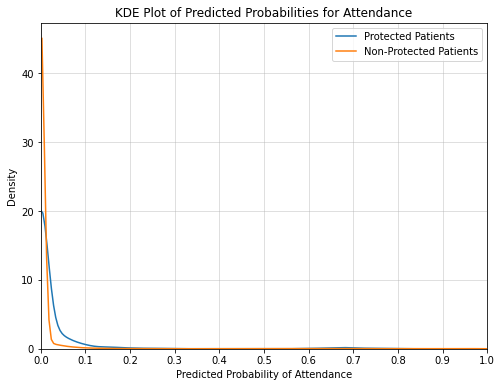

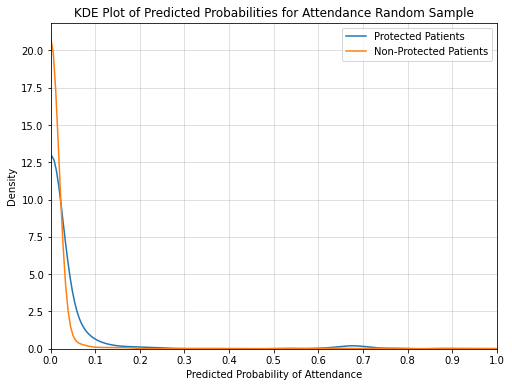

In [52]:
# Plotear probabilidades predecidas para la clase protegida y no protegida como un kdeplot
protected_probas = [patient.proba for patient in patients if patient.protected]
non_protected_probas = [patient.proba for patient in patients if not patient.protected]

plt.figure(figsize=(8, 6))
sns.kdeplot(protected_probas, label="Protected Patients")
sns.kdeplot(non_protected_probas, label="Non-Protected Patients")
plt.xlabel("Predicted Probability of Attendance")
plt.ylabel("Density")
plt.title("KDE Plot of Predicted Probabilities for Attendance")
plt.legend()
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.grid(alpha=0.5)
plt.show()

random_patient_list_ind = random_patient_sample(patients, sample_size)

protected_probas = [patient.proba for patient in random_patient_list_ind if patient.protected]
non_protected_probas = [patient.proba for patient in random_patient_list_ind if not patient.protected]

plt.figure(figsize=(8, 6))
sns.kdeplot(protected_probas, label="Protected Patients")
sns.kdeplot(non_protected_probas, label="Non-Protected Patients")
plt.xlabel("Predicted Probability of Attendance")
plt.ylabel("Density")
plt.title("KDE Plot of Predicted Probabilities for Attendance Random Sample")
plt.legend()
plt.grid(alpha=0.5)
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.show()

In [53]:
def random_patient_sample(patients, sample_size):

    # Pecentage of protected patients in the sample
    protected_pct = 0.5

    # Separate patients into the two classes
    protected_true = [patient for patient in patients if patient.protected]
    protected_false = [patient for patient in patients if not patient.protected]

    # Calculate sample sizes for each group 
    total_sample_size = sample_size
    sample_size_protected_true = int(total_sample_size * protected_pct)
    sample_size_protected_false = total_sample_size - sample_size_protected_true

    # Randomly select samples from each group
    sample_protected_true = [protected_true[i] for i in np.random.choice(len(protected_true), sample_size_protected_true, replace=False)]
    sample_protected_false = [protected_false[i] for i in np.random.choice(len(protected_false), sample_size_protected_false, replace=False)]

    # Final stratified sample
    stratified_sample = sample_protected_true + sample_protected_false

    # Shuffle the final sample
    np.random.shuffle(stratified_sample)

    return stratified_sample

In [54]:
def rule_Overbooking(patient, appointments, protected_threshold, non_protected_threshold, train_model):

    # Establece si hacer overbooking al paciente segun probabilidad y threshold

    if patient.protected:
        threshold = protected_threshold
    else:
        threshold = non_protected_threshold

    # Predict proba de inasistencia con el respectivo modelo
    patient.predict_proba(train_model)

    if patient.proba > threshold:
        overbook = True
    else:
        overbook = False

    # overbook = True if patient.proba>threshold else False
    
    # Si el paciente aun no se ha asignado 
    if not patient.assigned:

        start_day=patient.day_of_call
        
        # el dia final es el ultimo de la ventana de tiempo 
        # end_day=min(patient.day_of_call+6,len(appointments[0]))
        end_day=len(appointments[0])
        
        # Itera desde el dia que llama hasta el final
        for dia in range(start_day, end_day):

            # Itera sobre los slots del dia
            if not patient.assigned:
                for slot in range(len(appointments[0][dia])):
                    for server in range(len(appointments)):        
                        # Itera dentro de los slots para revisar asignaciones
                        for id in range(len(appointments[server][dia][slot])):
                            if overbook:
                                # Overbook si hay exactamente un paciente en ese slot
                                if appointments[server][dia][slot][id] is not None and len(appointments[server][dia][slot])==1:
                                    appointments[server][dia][slot].append(patient.id)
                                    patient.num_slot = slot
                                    patient.assigned = True
                                    break
                            if patient.assigned:
                                break  # romper ciclos si ya se asigno
                        if patient.assigned:
                            break  
                    if patient.assigned:
                        break 
                if patient.assigned:
                    break 

            # Si aun no se asigna es porque no se debe hacer overbooking
            if not patient.assigned:
                for slot in range(len(appointments[0][dia])):
                    for server in range(len(appointments)):        
                        for id in range(len(appointments[server][dia][slot])):
                            # asigna en un slot vacio (no overbooking)
                            if appointments[server][dia][slot][id] is  None :
                                appointments[server][dia][slot][id]= patient.id
                                patient.num_slot=slot
                                patient.assigned=True
                                break
                            if patient.assigned:
                                break
                        if patient.assigned:
                            break
                    if patient.assigned:
                        break
                if patient.assigned:
                    break  # Break from middle loop
            if patient.assigned:
                break
    
    return appointments

In [55]:
def call_a_rule (patient_list, appointments, name_rule, ml_model):
    refused_patients=0

    if name_rule=='custom_fifo':
        appointments, refused_patients = custom_fifo(patient_list, appointments, verbose=0)
        return appointments, refused_patients
    
    # Determinar procedimiento a usar segun rule name
    for patient in patient_list:

        if name_rule=='fifo':
            appointments = fifo(patient,appointments)
        
        elif name_rule=='overbooking_simple':

            # threshold og era 0.6
            protected_threshold = 0.3
            non_protected_threshold = 0.3

            appointments = rule_Overbooking(patient, appointments, protected_threshold, non_protected_threshold, ml_model)

        elif name_rule=='low_probability':
            appointments = low_probability(patient, appointments, 0.6, patient_list, ml_model)
        else:
            print("Unknown name_rule")
    
    if not patient.assigned:
        #print(f"Patient {patient.id} could not be assigned within the next {simulation_days} days")
        refused_patients += 1
    
    return appointments, refused_patients

In [56]:
# Opcion PPV NPV con cambio de decision

def scheduling_simulation(patients_data, appointments, simulation_days, 
                          num_serves, num_hours_byday, slot_time, 
                          overbooking,ml_model, benchmark=None):    
    
    protected_ppv = 0.18
    non_protected_ppv = 0.55

    protected_npv = 0.9
    non_protected_npv = 0.91

    # Determine attendance for all patients using random variables
    for patient in patients_data:

        if benchmark is None:
            patient.attendance=False if random.random() < patient.proba else True
        else:
            patient.attendance=False if random.random() < benchmark else True

        # Simulation based on PPV (no show predict precision) and NPV 
        if patient.protected and patient.attendance == True:
            patient.attendance = False if random.random() > protected_npv else True
        elif patient.protected and patient.attendance == False:
            patient.attendance = True if random.random() > protected_ppv else False
        elif not patient.protected and patient.attendance == True:
            patient.attendance = False if random.random() > non_protected_npv else True
        elif not patient.protected and patient.attendance == False:
            patient.attendance = True if random.random() > non_protected_ppv else False

    clinic = Clinic(patients_data, appointments, simulation_days, num_serves, simulation_days, num_hours_byday, slot_time, overbooking)
    clinic.simulation()
    
    # Return measures
    return clinic.get_measures()

In [57]:
extra_pct = 0.5
# np ceil rounds up
sample_size = int(np.ceil(available_slots + (available_slots * extra_pct)))

print(f"Sample size: {sample_size}")

# Initialize lists to store results
all_measures = []
historic_margin_errors = []
converge = False
iterations = 0

num_iterations = 5

# Perform Monte Carlo simulation
while not converge and iterations < num_iterations:

    start = time.time()

    iterations += 1

    # Initialize appointments (o luego hay bug en las asignaciones)
    appointments = []
    for _ in range(num_serves):
        server = [] 
        for _ in range(simulation_days):
            dia = []
            for _ in range(num_slots_byday):
                slot = [None]
                dia.append(slot) 
            server.append(dia)
        appointments.append(server)

    # se hace el muestreo de los pacientes
    random_patient_list = random_patient_sample(patients,sample_size)
    # se asigna el dia en el que llaman
    random_patient_list = asignar_dia(random_patient_list,simulation_days)

    appointments, num_refused = call_a_rule(random_patient_list, appointments, "overbooking_simple", rf)

    print(f"Appointments before scheduling simulation: {appointments}")

    # measures= scheduling_simulation(patients_data, appointments, simulation_days, num_serves, num_hours_byday, slot_time, overbooking, benchmark_umbral=0.6)
    
    measures = scheduling_simulation(random_patient_list, appointments, simulation_days, num_serves, work_hours, slot_time, overbooking,rf)
    
    print(f"Appointments after scheduling simulation: {appointments}")
    
    all_measures.append(measures)
    
    #print("measures:", measures)  # Debug print
    if iterations > 10 : 
        historic_margin_errors.append(get_margin_errors(all_measures)) # Debug
        converge = check_convergence(historic_margin_errors)
    
    end = time.time()

    print(f"Ran Successfully Iter {iterations}/{num_iterations} in {end-start:.2f}s\n") # Debug print

print(f"Ran Successfully All Iterations")# Debug print
# Convert measures to DataFrame for analysis
measures_df = pd.DataFrame(all_measures)

Sample size: 315
Appointments before scheduling simulation: [[[[0, 6], [1, 21], [2, 23], [3, 24], [4, 29], [5, 36], [7, 39], [8, 42], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [22], [25], [26], [27], [28], [30], [31], [32], [33], [34]], [[35, 49], [37, 51], [38, 53], [40, 76], [41], [43], [44], [45], [46], [47], [48], [50], [52], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70]], [[71, 90], [72, 94], [77, 100], [78, 104], [79, 105], [80, 123], [81, 125], [82], [83], [84], [85], [86], [87], [88], [89], [91], [92], [93], [95], [96], [97], [98], [99], [101], [102], [103], [106], [107], [108], [109]], [[110, 143], [111, 146], [112, 163], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [124], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [137], [138], [139], [140], [141], [142]], [[144, 180], [145, 183], [148, 200], [149, 206], [150, 211], [151, 219], [152, 221], [1

In [58]:
# Calculate mean, confidence interval, maximum, and minimum for each column
summary = []
for col in measures_df.columns:
    if isinstance(measures_df[col].iloc[0], list):  # Check if the column contains lists
        values = np.concatenate(measures_df[col].values)
        mean, margin_of_error = confidence_interval(values)
        lower_bound = max(0, mean - margin_of_error)
        upper_bound = mean + margin_of_error
        summary.append({
            "column": col,
            "mean": mean,
            "confidence_interval": (lower_bound, upper_bound),
            "minimum": np.min(values),
            "maximum": np.max(values)
        })
    else:
        mean, margin_of_error = confidence_interval(measures_df[col])
        lower_bound = max(0, mean - margin_of_error)
        upper_bound = mean + margin_of_error
        summary.append({
            "column": col,
            "mean": mean,
            "confidence_interval": (lower_bound, upper_bound),
            "minimum": measures_df[col].min(),
            "maximum": measures_df[col].max()
        })

# Create summary DataFrame
summary_measures_df = pd.DataFrame(summary)

# Print summary DataFrame
summary_measures_df

,column,mean,confidence_interval,minimum,maximum
0,idle_time_server,136.0,"(33.00922928283673, 238.9907707171633)",60.0,260.0
1,over_time,232.0,"(167.24272861165173, 296.7572713883483)",160.0,280.0
2,no_shows,31.4,"(25.945150868300523, 36.854849131699474)",28.0,39.0
3,clients_total_waiting_time non protected class,5256.0,"(4288.8720645037465, 6223.1279354962535)",4000.0,5900.0
4,clients_total_waiting_time protected class,5360.0,"(4758.081044622858, 5961.918955377142)",4760.0,5920.0
5,service_time,904.0,"(430.0810709704204, 1377.9189290295797)",440.0,1300.0
